# Классификация MNIST сверточной сетью

https://www.kaggle.com/c/digit-recognizer

In [2]:
import cv2
import numpy as np
import tensorflow as tf

print(tf.__version__)
print(tf.executing_eagerly())

2.4.1
True


In [3]:
train = np.loadtxt('../002/data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('../002/data/digit/test.csv', delimiter=',', skiprows=1)

In [4]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]

# приводим размерность к удобному для обаботки виду
# добавляем размерность канала
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28, 1))
test_img = np.resize(test, (test.shape[0], 28, 28, 1))

In [5]:
train_label

array([1., 0., 1., ..., 7., 6., 9.])

## Визуализируем исходные данные

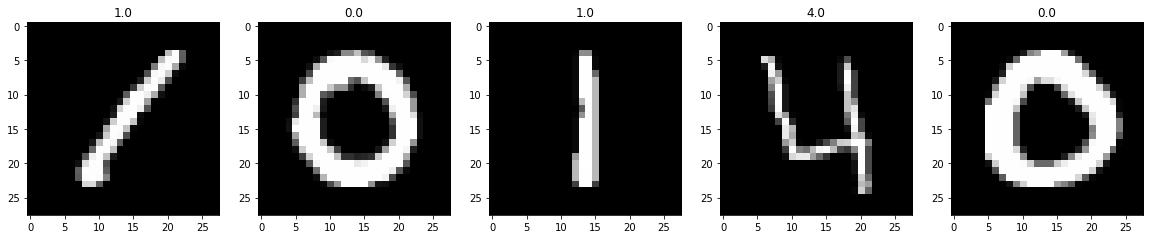

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5, :], 1):
    subplot = fig.add_subplot(1, 5, i)
    plt.imshow(img[:,:,0], cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Разбиваем выборку на обучение и валидацию

In [8]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_img, test_size=0.2, random_state=42)

## Собираем сверточную сеть для обучения

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=6,
                           kernel_size=(5, 5),
                           padding='same',
                           activation='relu',
                           input_shape=x_train.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    
    tf.keras.layers.Conv2D(filters=16, 
                           kernel_size=(5, 5),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                3

## One-hot кодировка разметки

In [11]:
y_train_labels = tf.keras.utils.to_categorical(y_train)

In [13]:
print(y_train.shape)
print(y_train_labels.shape)
print(x_train.shape)

(33600,)
(33600, 10)
(33600, 28, 28, 1)


## Запускаем обучение

In [ ]:
model.fit(x_train, 
          y_train_labels,
          batch_size=32, 
          epochs=5,
          validation_split=0.2)

## Предсказываем класс объекта

In [ ]:
y_pred = model.predict(x_val)
y_pred_labels = np.argmax(y_pred, axis=1)

## Оцениваем качество решение на валидационной выборке

In [ ]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, y_pred_labels))

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred_labels))

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_pred_labels)

plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

## Визуализируем предсказания для тестовой выборки

In [ ]:
y_pred_test = model.predict(test_img)
y_pred_test_labels = np.argmax(y_pred_test, axis=1)

In [ ]:
fig = plt.figure(figsize=(20, 10))
indices = np.random.choice(range(len(test_img)), 5)
img_prediction = zip(test_img[indices], y_pred_test_labels[indices])
for i, (img, pred) in enumerate(img_prediction, 1):
    subplot = fig.add_subplot(1, 5, i)
    plt.imshow(img[...,0], cmap='gray');
    subplot.set_title('%d' % pred);

## Готовим файл для отправки

In [ ]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(y_pred_test_labels, 1):
        dst.write('%s,%d\n' % (i, p))

In [ ]:
# Your submission scored 0.96814